In [3]:
import geopandas
import pandas
import pathlib
import numpy
import matplotlib
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

# Plan
* Load in GeoFabrics estimated width, depth and water surface height - (using those used in GeoFabrics - i.e. same level of smoothing)
  * Calculate channel area - assume rectangular
* Load in measured cross sections
  * Transform to NZVD2016
  * Calculate the channel area - use the same water height as the GeoFabrics estimates
* Compare the results
  * Take the nearest GeoFabrics cross section to each measured cross section
  * Plot area's on the same plot

In [15]:
sampling_resolution = 10
threshold = 1

### Load in GeoFabrics Bathymetry estimates

In [19]:
cache_path = pathlib.Path(fr"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\caches\100000000_new")
widths = geopandas.read_file(cache_path / "river_characteristics.geojson")
depths = geopandas.read_file(cache_path / "river_bathymetry.geojson")
main_channel = geopandas.read_file(cache_path / "rec_channel_100000000.geojson")

### Specify GeoFabric parameter
Both the column names used in calculations, and also select parameter file values

In [41]:
water_elevation_name = 'min_z_centre_unimodal'
full_width_name = 'widths_mean_0.25km'
flat_width_name = 'flat_widths_mean_0.25km'
threshold_name = 'thresholds_mean_0.25km'
rupp_bed_elevation_name = 'bed_elevation_Rupp_and_Smart'
neal_bed_elevation_name = 'bed_elevation_Neal_et_al'
min_bank_height= 0.75

#### Convert back to full bankfill area
Function to do the conversion

In [51]:
def to_full_bank_flow_area(depth_dataframe, width_dataframe, min_bank_height, threshold_name, full_width_name, flat_width_name, bed_elevation_name, water_elevation_name):
    
    # Calculate the depth for flat water
    depth = width_dataframe[water_elevation_name] - depth_dataframe[bed_elevation_name]
    # Calculate the area estimated for flat water width flow
    flat_water_area = depth * width_dataframe[full_width_name]

    # Add/correct for area along the bank edges (approximate as a triangle - two triangles = a rectange)
    bank_edge_area = (width_dataframe[full_width_name] - width_dataframe[flat_width_name]) \
        * (width_dataframe[threshold_name] - min_bank_height)

    # Calculate the area estimated for full bank width flow
    full_bank_area = flat_water_area + bank_edge_area

    return flat_water_area, full_bank_area
    

### Plot full bank flow area and flat water area
For Rupp and Smart

In [52]:
flat_water_area, full_bank_area = to_full_bank_flow_area(depth_dataframe=depths,
                                                         width_dataframe=widths,
                                                         min_bank_height=min_bank_height,
                                                         threshold_name=threshold_name,
                                                         full_width_name=full_width_name,
                                                         flat_width_name=flat_width_name,
                                                         bed_elevation_name=rupp_bed_elevation_name,
                                                         water_elevation_name=water_elevation_name)

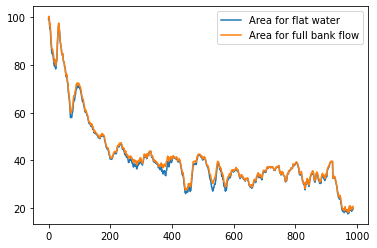

In [53]:
ax = matplotlib.pyplot.subplot()
flat_water_area.plot(ax=ax, label='Area for flat water')
full_bank_area.plot(ax=ax, label='Area for full bank flow')
ax.legend();

## Load in Measured cross sections
load in files including a raster for performing a local dataum conversion

In [55]:
cross_section_file = pathlib.Path(r"C:/Users/pearsonra/Documents/data/river_bathemetry/sections/Waikanae/Waikanae_Cross_Sections_NIWA/2014_Survey_XS_NZTM.shp")
cross_sections = geopandas.read_file(cross_section_file)
local_datum_file = pathlib.Path(r"C:\Users\pearsonra\Documents\data\local_datums\lds-wellington-1953-to-nzvd2016-conversion-raster-GTiff"
                                "\wellington-1953-to-nzvd2016-conversion-raster.tif")
import rioxarray
local_vertical_datum = rioxarray.rioxarray.open_rasterio(local_datum_file, masked=True)

### Perform LVD to NZVD2016 conversion

In [56]:
def get_lvd_conversion(geometry, local_vertical_datum):
    return local_vertical_datum.sel({'x': [geometry.x], 'y': [geometry.y]}, method='nearest').data[0,0,0]

cross_sections['lvd_conversion'] = cross_sections.apply(lambda row: get_lvd_conversion(row.geometry, local_vertical_datum), axis=1)
cross_sections['z_2016'] = cross_sections['Level'] - cross_sections['lvd_conversion']

### Get nearest estimated to measured cross section
Make cross sections geometries

In [68]:
section_centres = {'Section': [], 'geometry': []}
for section in cross_sections['Section'].unique():
    cross_section = cross_sections[cross_sections['Section'] == section]
    section_centre = cross_section[cross_section['Level']==cross_section['Level'].min()].iloc[0]
    section_centres['Section'].append(section_centre['Section'])
    section_centres['geometry'].append(section_centre['geometry'])
section_centres = geopandas.GeoDataFrame(section_centres, crs=main_channel.crs)

Cycle through each section identifying the nearest section in the key parameters

In [78]:
nearest_widths.columns

Index(['min_z_centre', 'min_z_centre_unimodal', 'min_z_water', 'slope',
       'min_z_centre_unimodal_mean_0.5km', 'slope_mean_0.5km',
       'min_z_centre_unimodal_mean_1.0km', 'slope_mean_1.0km',
       'min_z_centre_unimodal_mean_2.0km', 'slope_mean_2.0km',
       'min_z_centre_unimodal_mean_3.0km', 'slope_mean_3.0km', 'widths',
       'threshold', 'channel_count', 'flat_widths', 'valid', 'valid_widths',
       'valid_flat_widths', 'valid_threhold', 'widths_mean_0.15km',
       'flat_widths_mean_0.15km', 'thresholds_mean_0.15km',
       'widths_mean_0.2km', 'flat_widths_mean_0.2km', 'thresholds_mean_0.2km',
       'widths_mean_0.25km', 'flat_widths_mean_0.25km',
       'thresholds_mean_0.25km', 'widths_mean_2.0km', 'flat_widths_mean_2.0km',
       'thresholds_mean_2.0km', 'widths_mean_3.0km', 'flat_widths_mean_3.0km',
       'thresholds_mean_3.0km', 'geometry'],
      dtype='object')

In [99]:
nearest_cross_sections = numpy.zeros_like(widths[water_elevation_name], dtype=bool)
nearest_sections_ids = numpy.zeros_like(widths[water_elevation_name])
for index, row in section_centres.iterrows():
    nearest_cross_sections[widths.distance(row.geometry).argmin()] = True
    nearest_sections_ids[widths.distance(row.geometry).argmin()] = row['Section']

nearest_widths = widths[nearest_cross_sections]
nearest_depths = depths[nearest_cross_sections]
nearest_widths.insert(loc=0, column='Section', value=nearest_sections_ids[nearest_cross_sections])
nearest_depths.insert(loc=0, column='Section', value=nearest_sections_ids[nearest_cross_sections])

### Calculate cross sectional area of each profile
From flat water height, and also the bank-full height. Cycle through sections taking each section.
Add a check to ensure no gap - i.e. portion of the channel above water then below again

In [121]:
section_label = 10.0
section = cross_sections[cross_sections['Section'] == section_label]
section = section[section['z_2016'] < nearest_widths[nearest_widths['Section'] == section_label][water_elevation_name].mean()]

In [129]:
section['Offset'].rolling(window=2).apply(numpy.diff)

8      NaN
9     1.89
10    1.68
11    1.69
12    1.66
13    1.77
14    1.73
15    1.63
16    1.69
17    1.95
18    1.91
19    2.01
20    2.09
21    2.00
22    1.81
23    1.97
24    1.98
25    1.96
26    1.93
27    1.95
28    1.92
29    1.94
30    2.01
31    1.97
32    1.20
33    0.59
34    0.64
35    0.74
Name: Offset, dtype: float64

In [122]:
section[['Offset', 'z_2016']].head(2)

,Offset,z_2016
8,15.81,-0.336669
9,17.70,-0.506669


In [130]:
section['Offset']

8     15.81
9     17.70
10    19.38
11    21.07
12    22.73
13    24.50
14    26.23
15    27.86
16    29.55
17    31.50
18    33.41
19    35.42
20    37.51
21    39.51
22    41.32
23    43.29
24    45.27
25    47.23
26    49.16
27    51.11
28    53.03
29    54.97
30    56.98
31    58.95
32    60.15
33    60.74
34    61.38
35    62.12
Name: Offset, dtype: float64

# Translate the samples to correct reach

## Measured cross sections

Plot minimum height (i.e height of the bed)

Pull out the centre point for each section - for idntification of the nearest sampled transect

## Plot the depths of the two approaches

### Compare the depth results to measured

In [ ]:
f, ax = matplotlib.pyplot.subplots(figsize=(10, 6))
(nearest_key_parameters[min_z_name]-nearest_key_parameters['depth_Neal_et_al']).reset_index(drop=True).plot(label='Bed elevation calculated Neal et al')
(nearest_key_parameters[min_z_name]-nearest_key_parameters['depth_Smart_et_al']).reset_index(drop=True).plot(label='Bed elevation calculated Rupp & Smart')
cross_sections.groupby('Section')['z_2016'].min().reset_index(drop=True).plot(label='Measured cross-section')
ax.set(title="Bed elevations estimated and measured")
matplotlib.pyplot.xlabel(f"Transect number where there are measured cross sections")
matplotlib.pyplot.ylabel(f"River bed elevation in m");
matplotlib.pyplot.legend()

Plot the nearest widths

### Plot other values
* Widths - nearest the measured cross sections
* Measured cross section depth compared to water surface height

In [ ]:
f, ax = matplotlib.pyplot.subplots(figsize=(20, 6))
nearest_key_parameters[[width_name]].reset_index(drop=True).plot(ax=ax)
ax.set(title="Estimated width nearest to measured cross section")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"Channel width (m)");
matplotlib.pyplot.legend()

In [ ]:
f, ax = matplotlib.pyplot.subplots(figsize=(20, 6))
nearest_key_parameters[['min_z_centre_unimodal', 'min_z_centre']].reset_index(drop=True).plot(ax=ax)
cross_sections.groupby('Section')['z_2016'].min().reset_index(drop=True).plot(ax=ax, label='Measured cross-section depth')
ax.set(title="Measured depth compared to estimated water surface elevation")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"Elevation (m)");
matplotlib.pyplot.legend()

### Plots exploring the change to width to produce an expected bed elevation

In [ ]:
fudge_factor = 2
depth_wider = (nearest_key_parameters['mannings_n'] * nearest_key_parameters['flow'] / (numpy.sqrt(nearest_key_parameters['slope']) * nearest_key_parameters['widths_Savgol'] * fudge_factor)) ** (3/5) - threshold

f, ax = matplotlib.pyplot.subplots(figsize=(20, 6))
(nearest_key_parameters['min_z_centre_unimodal']-depth_wider).reset_index(drop=True).plot(label='Calculated from unimodal min_z')
(nearest_key_parameters['min_z_centre_unimodal_0.5km_rolling_mean'] - depth_wider).reset_index(drop=True).plot(label='Calculated from smooth unimodal min_z')
(nearest_key_parameters['min_z_centre']-depth_wider).reset_index(drop=True).plot(label='Calculated from min_z')
cross_sections.groupby('Section')['z_2016'].min().reset_index(drop=True).plot(label='Measured cross-section')
ax.set(title=f"Depths estimated using the Uniform Flow Throery approach with width mutiplier of {fudge_factor}")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River depth in m");
matplotlib.pyplot.legend()

In [ ]:
fudge_factor = 2
depth_wider = (nearest_key_parameters['flow'] / (K_0 * nearest_key_parameters['widths_Savgol'] * fudge_factor * nearest_key_parameters['slope'] ** b)) ** (1 / (1+a)) - threshold

f, ax = matplotlib.pyplot.subplots(figsize=(20, 6))
(nearest_key_parameters['min_z_centre_unimodal']-depth_wider).reset_index(drop=True).plot(label='Calculated from unimodal min_z')
(nearest_key_parameters['min_z_centre_unimodal_0.5km_rolling_mean']-depth_wider).reset_index(drop=True).plot(label='Calculated from smooth unimodal min_z')
(nearest_key_parameters['min_z_centre']-depth_wider).reset_index(drop=True).plot(label='Calculated from min_z')
cross_sections.groupby('Section')['z_2016'].min().reset_index(drop=True).plot(label='Measured cross-section')
ax.set(title=f"Depths estimated using the conceptual multivariate regression approach with width mutiplier of {fudge_factor}")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River depth in m");
matplotlib.pyplot.legend()

### Mics plots for reference: 
Water levels for 10m spaced transects

In [ ]:
f, ax = matplotlib.pyplot.subplots(figsize=(10, 3))
key_parameters[['min_z_centre_unimodal', 'min_z_centre_unimodal_0.5km_rolling_mean', 'min_z_centre']].plot(ax=ax, linewidth=2)
ax.set(title=f"Water surface as calculated from sampled transects")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"Water surface elevation");

Widths at 10m spacing

In [ ]:
f, ax = matplotlib.pyplot.subplots(figsize=(10, 3))
key_parameters[['widths_Savgol']].plot(ax=ax, linewidth=2)
ax.set(title="Channel width (m)")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"Estimated channel width");